In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [8]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'maize flour' 

In [9]:
location_ids = pd.read_csv(input_data_path)
location_ids = location_ids[(location_ids.vehicle==vehicle)].location_id.unique().tolist()

In [10]:
location_ids

[190, 189, 196, 201, 180]

In [11]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [12]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
190    1.712028
189    1.712028
196    1.712028
201    1.712028
180    1.712028
dtype: float64

In [13]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [14]:
data = create_marginal_uncertainty(data)

In [15]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
48,190,Uganda,total population,maize flour,percent of population eating fortified vehicle,folic acid,6.5,3.3,9.7
52,190,Uganda,total population,maize flour,percent of population eating industrially prod...,na,42.4,32.7,52.1
53,190,Uganda,total population,maize flour,percent of population eating vehicle,na,91.8,87.7,96.0
63,189,United Republic of Tanzania,total population,maize flour,percent of population eating fortified vehicle,folic acid,2.5,1.3,3.7
67,189,United Republic of Tanzania,total population,maize flour,percent of population eating industrially prod...,na,36.6,29.2,44.0


In [16]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [17]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [18]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [19]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [20]:
paf_ntds_nofort.mean(axis=1)

location_id
190    0.395330
189    0.405397
196    0.226370
201    0.411496
180    0.411496
dtype: float64

In [21]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [22]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
180         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
180         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
180         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
180         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
180         2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
180         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
180         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
180         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [23]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [24]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [25]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [26]:
dalys_averted_u5.head()

draw_0       draw_1       draw_2  \
location_id year_id coverage_level                                          
180         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             1465.117396  1208.149733  1517.931445   
                    0.5             3662.793490  3020.374333  3794.828612   

                                         draw_3       draw_4       draw_5  \
location_id year_id coverage_level                                          
180         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              970.408788  1193.050716  1154.898108   
                    0.5             2426.021969  2982.626790  2887.245270   

                                         draw_6       draw_7       draw_8  \
location_id year_id coverage_level                                          
180         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              710.114364   587.050499   987.630611   
                    0.5             1775.285910  1467.626248  2469.076526   

                                         draw_9  ...     draw_990  \
location_id year_id coverage_level               ...                
180         2022    0.2                0.000000  ...     0.000000   
                    0.5                0.000000  ...     0.000000   
                    0.8                0.000000  ...     0.000000   
            2023    0.2             1295.673524  ...  1212.729732   
                    0.5             3239.183810  ...  3031.824330   

                                       draw_991    draw_992     draw_993  \
location_id year_id coverage_level                                         
180         2022    0.2                0.000000     0.00000     0.000000   
                    0.5                0.000000     0.00000     0.000000   
                    0.8                0.000000     0.00000     0.000000   
            2023    0.2             1886.655051  1648.27318  1273.292459   
                    0.5             4716.637628  4120.68295  3183.231148   

                                       draw_994     draw_995     draw_996  \
location_id year_id coverage_level                                          
180         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              403.064272  1823.196942  1324.323580   
                    0.5             1007.660680  4557.992355  3310.808949   

                                       draw_997     draw_998     draw_999  
location_id year_id coverage_level                                         
180         2022    0.2                0.000000     0.000000     0.000000  
                    0.5                0.000000     0.000000     0.000000  
                    0.8                0.000000     0.000000     0.000000  
            2023    0.2             1091.031688  1188.570420  1628.982018  
                    0.5             2727.579220  2971.426049  4072.455044  

[5 rows x 1000 columns]

In [28]:
vehicle_name = vehicle.replace(" ","_")

'maize_flour'

In [26]:
dalys_averted_path = f'/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_{vehicle_name}_dalys_averted_folic_acid_03_26_2021.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [27]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [28]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [29]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,180,2022,0.2,0.000000,0.000000,0.000000,6.416043e+06,0.000000,0.000000,0.000000
1,180,2022,0.5,0.000000,0.000000,0.000000,6.416043e+06,0.000000,0.000000,0.000000
2,180,2022,0.8,0.000000,0.000000,0.000000,6.416043e+06,0.000000,0.000000,0.000000
3,180,2023,0.2,996.582913,407.517597,1823.512625,6.416043e+06,15.532673,6.351541,28.421142
4,180,2023,0.5,2491.457284,1018.793992,4558.781563,6.416043e+06,38.831681,15.878853,71.052855


# viz results

In [30]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

KeyError: 179

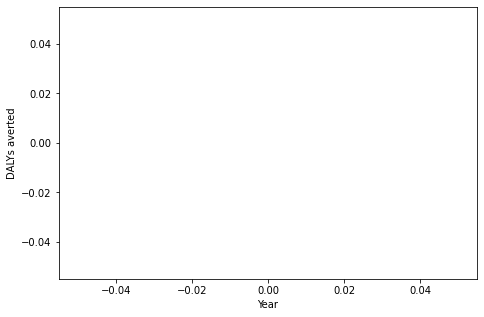

In [31]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


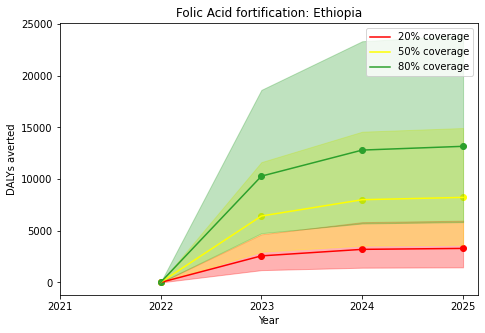

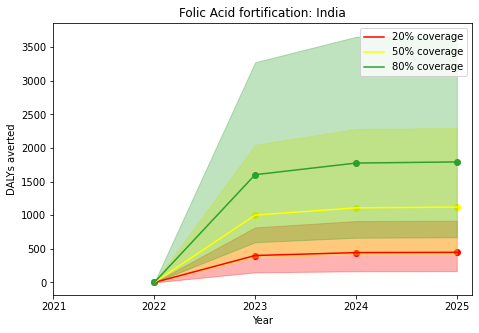

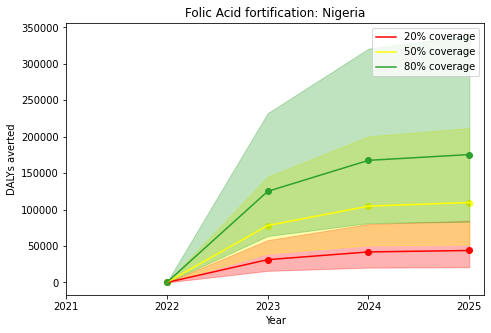

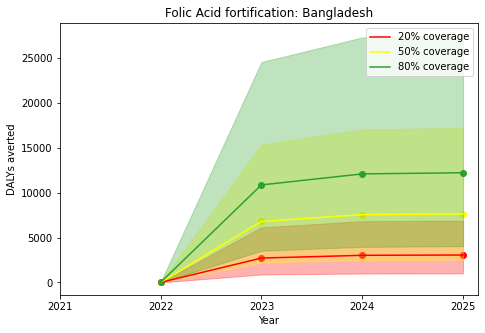

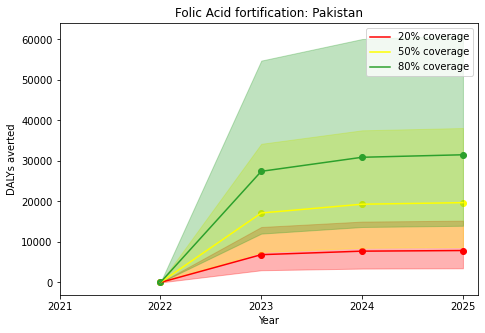

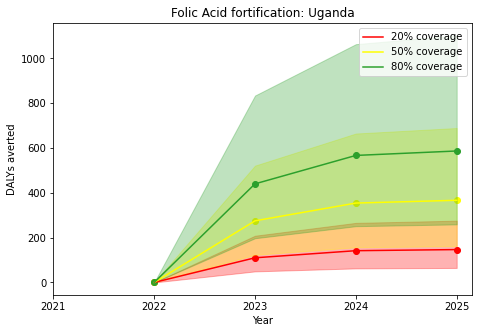

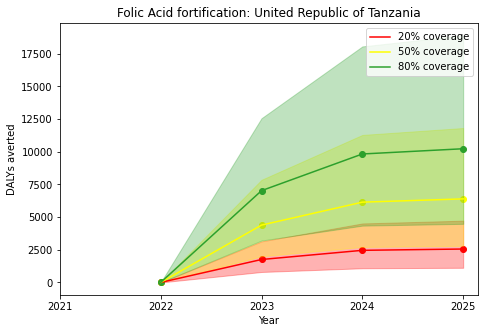

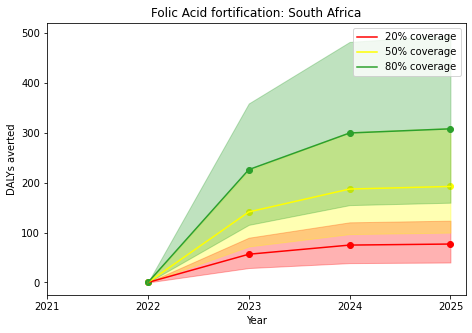

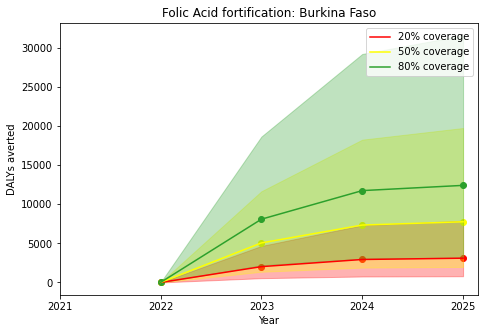

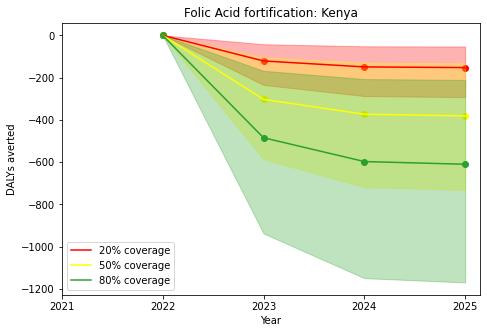

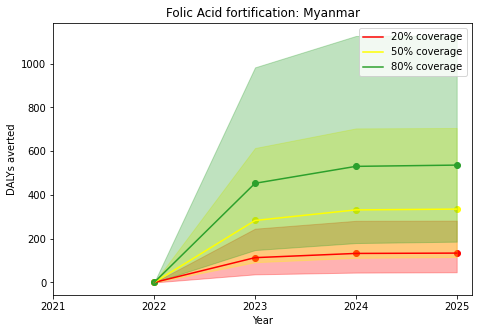

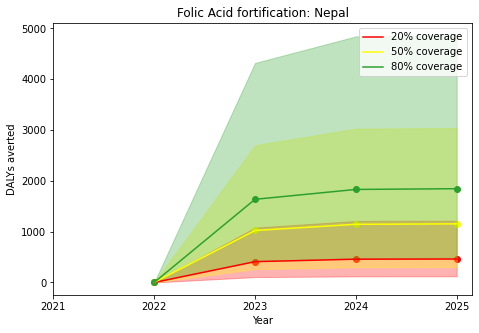

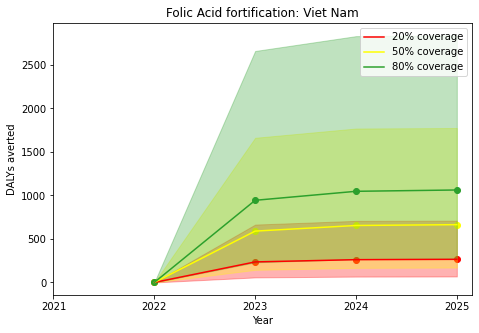

In [65]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


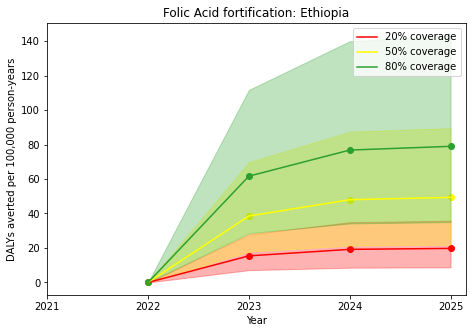

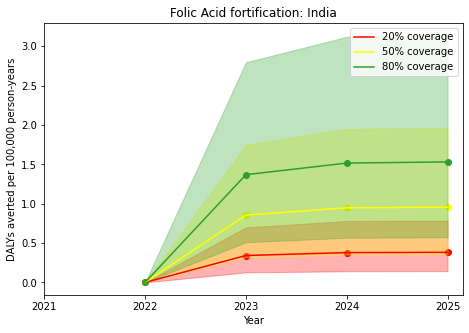

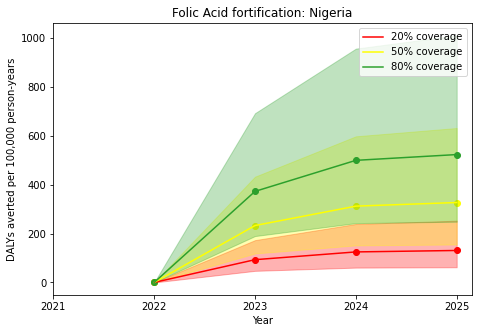

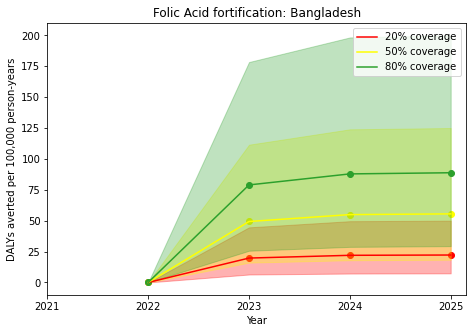

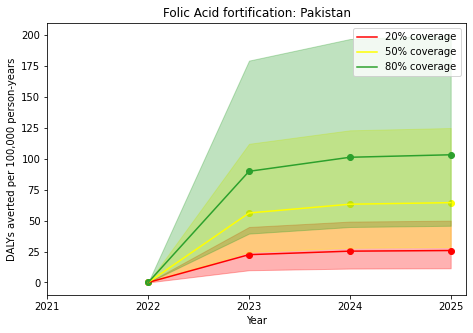

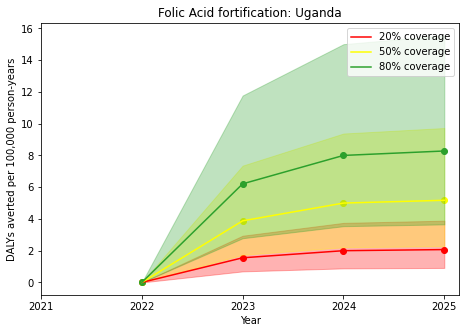

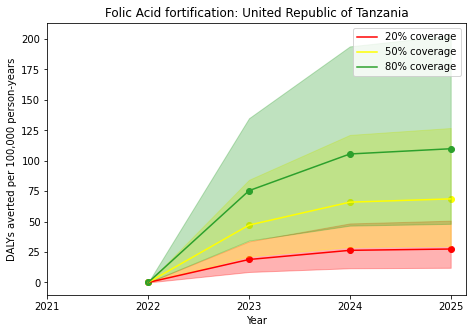

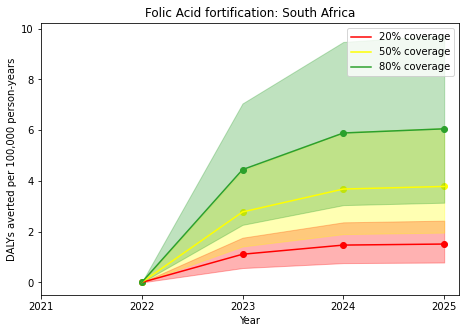

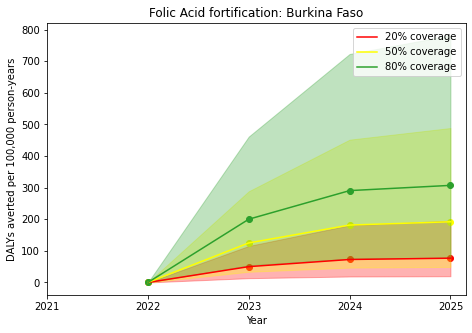

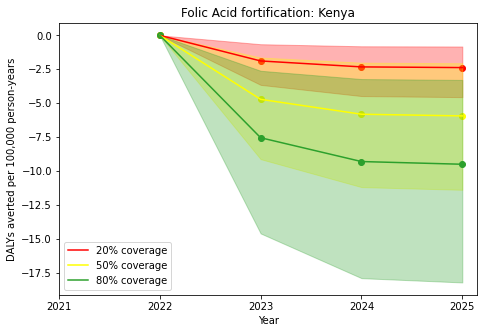

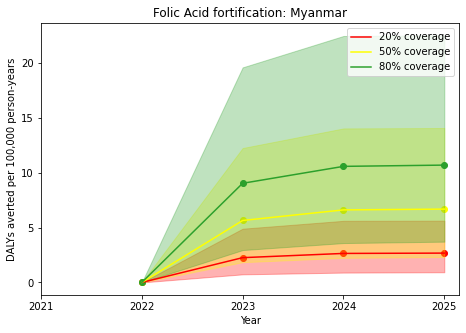

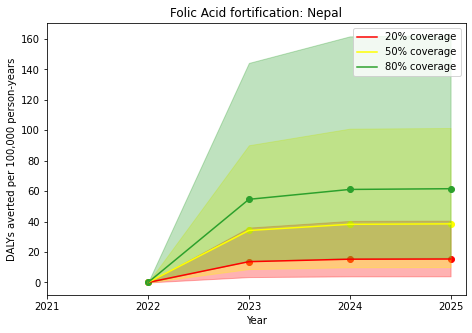

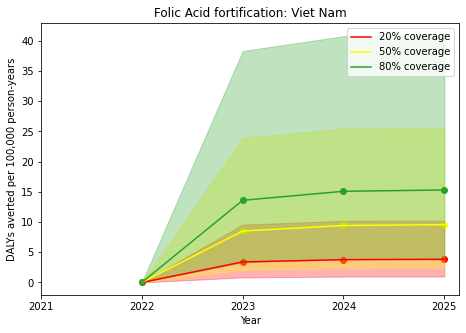

In [72]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


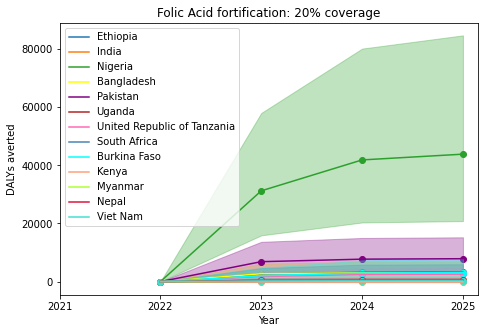

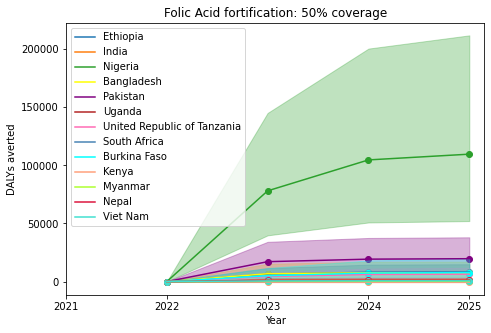

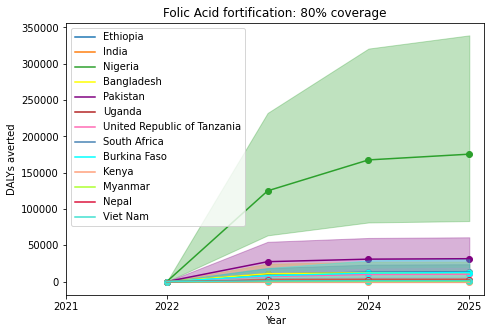

In [74]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
              'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for i in range(len(location_ids)):
            loc = location_ids[i]
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


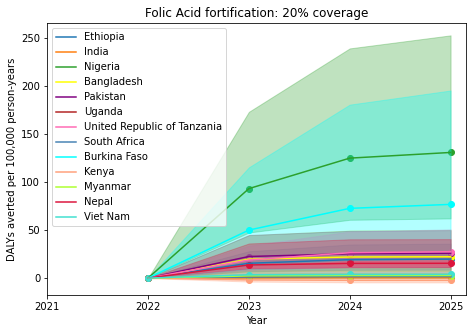

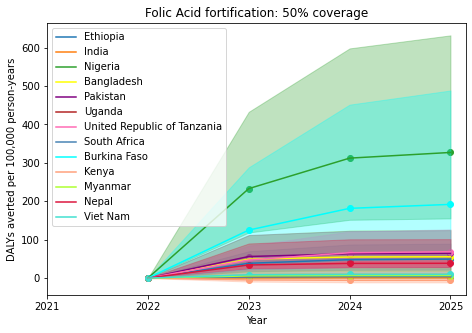

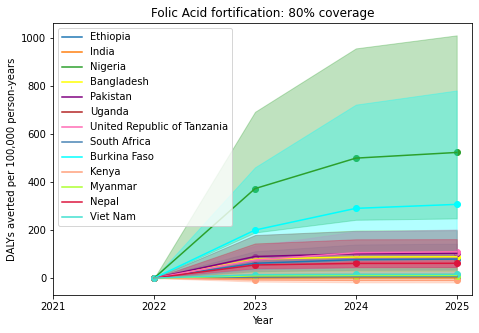

In [75]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
              'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

    for level in alternative_scenario_coverage_levels:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for i in range(len(location_ids)):
            loc = location_ids[i]

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)

In [78]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Kenya") & (inputs.nutrient=="folic acid")]



,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
105,180,Kenya,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000000,0.00000,0.000000
114,180,Kenya,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,34.703333,15.25348,54.153186


In [79]:
inputs[(inputs.location_name=="Kenya") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
104,180,Kenya,total population,maize flour,percent of population eating industrially prod...,na,36.67,17.221861,56.118139
113,180,Kenya,total population,wheat flour,percent of population eating industrially prod...,na,30.95,13.603743,48.296257
